# Clusterización
***

Vamos a ver este temita.
Acá en este párrafo introductorio me gustaría escribir un breve resumen de lo que hagamos, pero lo voy a saber recién cuando tenga algo jeje.
***

Empezamos por importar las librerías y módulos que vamos a usar

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import PIL
from PIL import Image
from matplotlib import image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.2.0


Y luego vamos a cargar dos funciones que van a ser claves en el trabajo.

1. `rgb_to_hsv`: Función que recibe RGB y devuelve HSV

2. `hsv_to_rgb`: Función que recibe HSV y devuelve RGB

In [97]:
def rgb_to_hsv(rgb):
    """
    >>> from colorsys import rgb_to_hsv as rgb_to_hsv_single
    >>> 'h={:.2f} s={:.2f} v={:.2f}'.format(*rgb_to_hsv_single(50, 120, 239))
    'h=0.60 s=0.79 v=239.00'
    >>> 'h={:.2f} s={:.2f} v={:.2f}'.format(*rgb_to_hsv_single(163, 200, 130))
    'h=0.25 s=0.35 v=200.00'
    >>> np.set_printoptions(2)
    >>> rgb_to_hsv(np.array([[[50, 120, 239], [163, 200, 130]]]))
    array([[[   0.6 ,    0.79,  239.  ],
            [   0.25,    0.35,  200.  ]]])
    >>> 'h={:.2f} s={:.2f} v={:.2f}'.format(*rgb_to_hsv_single(100, 100, 100))
    'h=0.00 s=0.00 v=100.00'
    >>> rgb_to_hsv(np.array([[50, 120, 239], [100, 100, 100]]))
    array([[   0.6 ,    0.79,  239.  ],
           [   0.  ,    0.  ,  100.  ]])
    """
    input_shape = rgb.shape
    rgb = rgb.reshape(-1, 3)
    r, g, b = rgb[:, 0], rgb[:, 1], rgb[:, 2]

    maxc = np.maximum(np.maximum(r, g), b)
    minc = np.minimum(np.minimum(r, g), b)
    v = maxc

    deltac = maxc - minc
    s = deltac / maxc
    deltac[deltac == 0] = 1  # to not divide by zero (those results in any way would be overridden in next lines)
    rc = (maxc - r) / deltac
    gc = (maxc - g) / deltac
    bc = (maxc - b) / deltac

    h = 4.0 + gc - rc
    h[g == maxc] = 2.0 + rc[g == maxc] - bc[g == maxc]
    h[r == maxc] = bc[r == maxc] - gc[r == maxc]
    h[minc == maxc] = 0.0

    h = (h / 6.0) % 1.0
    res = np.dstack([h, s, v])
    return res.reshape(input_shape)


def hsv_to_rgb(hsv):
    """
    >>> from colorsys import hsv_to_rgb as hsv_to_rgb_single
    >>> 'r={:.0f} g={:.0f} b={:.0f}'.format(*hsv_to_rgb_single(0.60, 0.79, 239))
    'r=50 g=126 b=239'
    >>> 'r={:.0f} g={:.0f} b={:.0f}'.format(*hsv_to_rgb_single(0.25, 0.35, 200.0))
    'r=165 g=200 b=130'
    >>> np.set_printoptions(0)
    >>> hsv_to_rgb(np.array([[[0.60, 0.79, 239], [0.25, 0.35, 200.0]]]))
    array([[[  50.,  126.,  239.],
            [ 165.,  200.,  130.]]])
    >>> 'r={:.0f} g={:.0f} b={:.0f}'.format(*hsv_to_rgb_single(0.60, 0.0, 239))
    'r=239 g=239 b=239'
    >>> hsv_to_rgb(np.array([[0.60, 0.79, 239], [0.60, 0.0, 239]]))
    array([[  50.,  126.,  239.],
           [ 239.,  239.,  239.]])
    """
    input_shape = hsv.shape
    hsv = hsv.reshape(-1, 3)
    h, s, v = hsv[:, 0], hsv[:, 1], hsv[:, 2]

    i = np.int32(h * 6.0)
    f = (h * 6.0) - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))
    i = i % 6

    rgb = np.zeros_like(hsv)
    v, t, p, q = v.reshape(-1, 1), t.reshape(-1, 1), p.reshape(-1, 1), q.reshape(-1, 1)
    rgb[i == 0] = np.hstack([v, t, p])[i == 0]
    rgb[i == 1] = np.hstack([q, v, p])[i == 1]
    rgb[i == 2] = np.hstack([p, v, t])[i == 2]
    rgb[i == 3] = np.hstack([p, q, v])[i == 3]
    rgb[i == 4] = np.hstack([t, p, v])[i == 4]
    rgb[i == 5] = np.hstack([v, p, q])[i == 5]
    rgb[s == 0.0] = np.hstack([v, v, v])[s == 0.0]

    return rgb.reshape(input_shape)

Vamos a cargar la imagen con la que vamos a trabajar y la mostramos por pantalla

(2304, 3072, 3)


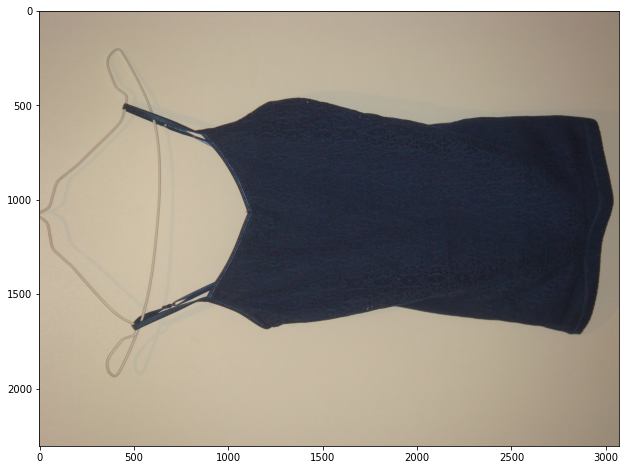

In [98]:
foto1 = image.imread('DSC01535.JPG')
# foto1 = image.imread('DSC01537.JPG')
plt.figure(figsize=(12, 8))
plt.imshow(foto1)
print(foto1.shape)

Vemos que el **shape** de la imagen es 2304 filas por 3072 columnas en 3 canales.

Ahora, como la imagen es muy grande, vamos a *downsamplearla* de forma tal de trabajar con menos cantidad de píxeles (por comodidad)

In [99]:
dsamp = 15
# El slice ::dsamp significa "agarrá todo cada 15 unidades", es decir, agarra 0, 15, 30, ...
# Eso lo hace en X y en Y para los 3 canales
foto_apil1 = foto1[::dsamp, ::dsamp, :]
# foto_apil1 = foto1

(154, 205, 3)


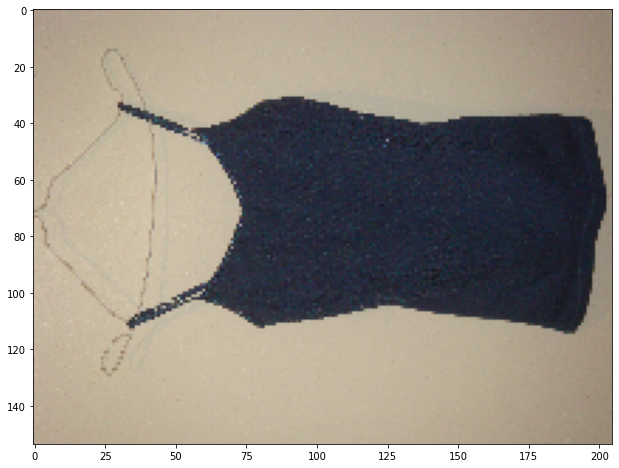

In [100]:
plt.figure(figsize=(12, 8))
plt.imshow(foto_apil1)
print(foto_apil1.shape)

Ahí vemos que tenemos la imagen anterior *pixelada*, osea, con menos puntos o con menos **dpi**.

El **shape** de la nueva imagen es de 154 filas por 205 columnas, en 3 canales.

Luego pasamos la imagen, que está en RGB a HSV (<em><b>H</b>ue, <b>S</b>aturation, <b>V</b>alue</em> o Matiz, Saturación, Valor).

Además, extraemos estas 3 matrices a variables individuales H, S y V.

El tipo de dato es entero sin signo de 8-bit

In [101]:
# foto_hsv = rgb_to_hsv(foto_apil1)
foto_hsv = foto_apil1
# Acá separo los resultados para los distintos parámetros
H = foto_hsv[:,:,0]
S = foto_hsv[:,:,1]
V = foto_hsv[:,:,2]

In [102]:
fil, col = np.shape(V)
print(f'{fil} filas, {col} columnas')

154 filas, 205 columnas


La idea ahora es hacer un **reshape** para meter en una sola lista (o vector) cada uno de los canales.

Para esto:

In [103]:
R = np.double( H.reshape(fil*col, 1, order='F') )
G = np.double( S.reshape(fil*col, 1, order='F') )
B = np.double( V.reshape(fil*col, 1, order='F') )La idea ahora es hacer un **reshape** para meter en una sola lista (o vector) cada uno de los canales.

Para esto:La idea ahora es hacer un **reshape** para meter en una sola lista (o vector) cada uno de los canales.

Para esto:La idea ahora es hacer un **reshape** para meter en una sola lista (o vector) cada uno de los canales.

Para esto:La idea ahora es hacer un **reshape** para meter en una sola lista (o vector) cada uno de los canales.

Para esto:

***
**Nota**: 

lo de `order = 'F'` es por como va a hacer el reshape la función. Si le decís **F** ordena primero el primer elemento de cada **Fila**, luego el segundo y así. Si le decís **C** ordena primero la primer fila (entera), luego la segunda, y así.

```python
mat = np.array([[1, 2, 3], [4, 5, 6]])
mat_F = mat.reshape(6, order = 'F')
mat_C = mat.reshape(6, order = 'C')
print(mat)
print(mat_F)
print(mat_C)
```

Output:
```python
[[1 2 3]
 [4 5 6]]
[1 4 2 5 3 6]
[1 2 3 4 5 6]
```
***

Vemos la forma de alguno de estos muchachos

In [104]:
R.shape

(31570, 1)

Y concatenamos estos tres vectores en una matriz

In [105]:
H = np.c_[R, G, B]

In [106]:
H.shape

(31570, 3)

***
## Acá empieza la parte de clusterización

Primero creamos un lista que va a albergar los resultados de **KMeans** para cada número **k** de clústers.

In [107]:
Sum_of_squared_distances = []
K = range(1, 6)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(H)
    Sum_of_squared_distances.append(km.inertia_)

Y ahora ploteamos un gráfico que te muestra cómo desciende la *suma del cuadrado de las distancias* con el aumento de número de clústers.

Text(0.5, 1.0, 'Elbow Method For Optimal k')

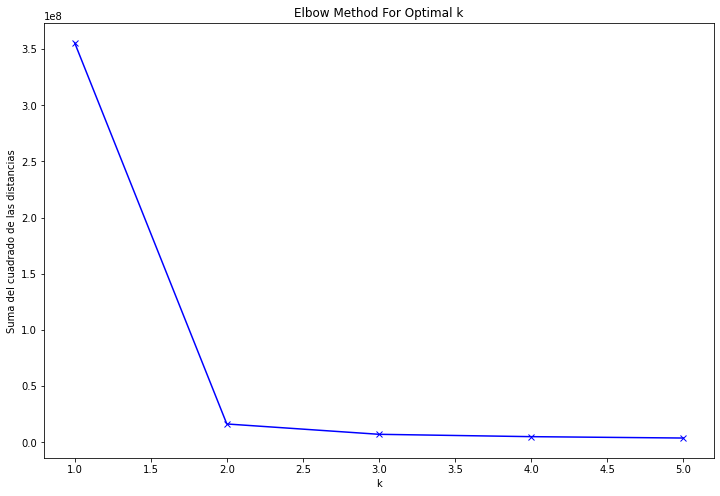

In [108]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(K, Sum_of_squared_distances,
        linestyle='-',
        color='blue',
        marker='x')

ax.set_xlabel('k')
ax.set_ylabel('Suma del cuadrado de las distancias')
ax.set_title('Elbow Method For Optimal k')

Nos quedamos con número de clústers igual a 2 que es el que tiene más sentido.

In [109]:
kmeans_aux = KMeans(n_clusters=2, random_state=0)
kmeans = kmeans_aux.fit(H)

In [110]:
kmeans.labels_.shape

(31570,)

Text(0.5, 0, 'Blue')

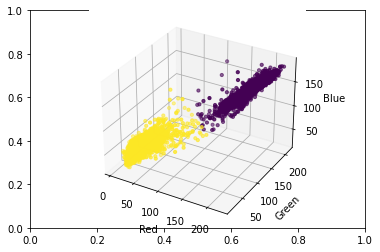

In [111]:
# %matplotlib widget
%matplotlib inline

fig, ax3d = plt.subplots()
ax3D = fig.add_subplot(111, projection='3d')
ax3D.scatter( H[:,0], H[:,1], H[:,2], 
             s=10, 
             c=kmeans.labels_, 
             marker='o')
ax3D.set_xlabel('Red')
ax3D.set_ylabel('Green')
ax3D.set_zlabel('Blue')

Text(0.5, 1.0, 'Imagen clusterizada')

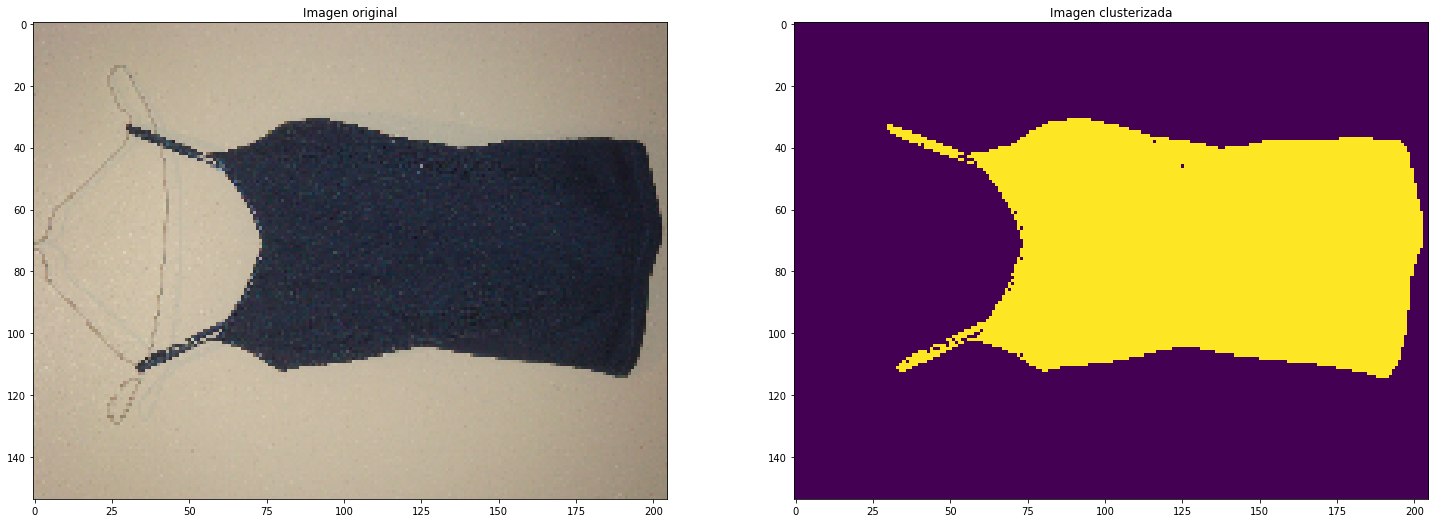

In [112]:
T = kmeans.labels_

mT = T.reshape(fil, col, order='F')

fig, ax = plt.subplots(1, 2, figsize=(25, 10))
ax[0].imshow(foto_apil1)
ax[0].set_title('Imagen original')
ax[1].imshow(mT)
ax[1].set_title('Imagen clusterizada')

In [113]:
T.shape

(31570,)

LO QUE ME QUEDA HACER:

- Terminar de comentar bien la última parte
- Embellecer un poco el asunto